In [1]:
from itertools import combinations
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib
import rosbag
import hmms
import pickle
import os

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
rejection_negative_bias = 0
pbl_negative_bias = 2
pbr_negative_bias = 0
rotl_negative_bias = 0
rotr_negative_bias = 0
pc_negative_bias = 0

K = 3
random_state = 1

classes = ["PBL", "PBR", "ROL", "ROR", "PC", "Rejections"]

In [3]:
pblHMM = hmms.DtHMM.from_file("pblHMM.npz")
pbrHMM = hmms.DtHMM.from_file("pbrHMM.npz")
rotlHMM = hmms.DtHMM.from_file("rotlHMM.npz")
rotrHMM = hmms.DtHMM.from_file("rotrHMM.npz")
pcHMM = hmms.DtHMM.from_file("pcHMM.npz")
uniform_HMM = hmms.DtHMM.from_file("uniform_HMM.npz")

In [4]:
# Load validation QTC_C sequences (recorded in lab)
rotl_lab_seqs = []
rotr_lab_seqs = []
pb_l_lab_seqs = []
pb_r_lab_seqs = []
pc_lab_seqs = []
u_lab_seqs = []

with open("study_qtc_seqs.pickle", "rb") as f:
    lab_seqs = pickle.load(f)
lab_seqs

{'pcr_4': ['---+', '-+-+', '---+', '-+-+', '-+0+', '-+++', '--++'],
 'rotl_10': ['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '00-+',
  '0--+'],
 'rotl_11': ['-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '---+',
  '---0',
  '-0-0',
  '-0-+',
  '---+',
  '-0-+',
  '-+-+',
  '-0-+',
  '---+',
  '---0',
  '-0-0',
  '-0--',
  '00--',
  '00-0',
  '00-+',
  '0--+',
  '0--0',
  '00-0',
  '0+--',
  '+0-0',
  '+0--',
  '+0-0',
  '+--0',
  '+--+',
  '+--0',
  '+--+',
  '+0-+',
  '+--+',
  '+0-+',
  '+--+'],
 'rotl_12': ['-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '-+-+',
  '-0-+',
  '00-+',
  '0--+',
  '00-+'],
 'pbl_10': ['----', '0---', '+---', '+0--', '++--', '++0-', '+++-', '+-+-'],
 'pbl_11': ['----',
  '0---',
  '+0--',
  '++--',
  '++0-',
  '+-0-',
  '+-+-',
  '+-++',
  '+-+0',
  '+-++',
  '+-0+'],
 'pbl_12': ['---+',
  '---0',
  '----',
  '---0',
  '----',
  '+---',
  '++--',
  '++0-',
  '+++-'],
 'pcr_1': ['0--+', '---+', '-0-+', '-

In [5]:
rotl_bag_codes = []
rotr_bag_codes = []
pb_l_bag_codes = []
pb_r_bag_codes = []
pc_bag_codes = []
u_bag_codes = []

In [6]:
for key in lab_seqs.keys():
    class_code = key.split("_")[0]
    
    if key.split("_")[0] == "rotl":
        rotl_lab_seqs.append(lab_seqs[key])
        rotl_bag_codes.append(key)
    elif key.split("_")[0] == "rotr":
        rotr_lab_seqs.append(lab_seqs[key])
        rotr_bag_codes.append(key)
    elif "pb" in class_code:
        if "l" in class_code:
            pb_l_lab_seqs.append(lab_seqs[key])
            pb_l_bag_codes.append(key)
        else:
            pb_r_lab_seqs.append(lab_seqs[key])
            pb_r_bag_codes.append(key)
    elif "pc" in class_code:
        pc_lab_seqs.append(lab_seqs[key])
        pc_bag_codes.append(key)
    else:
        u_lab_seqs.append(lab_seqs[key])
        u_bag_codes.append(key)
        
print(len(rotl_lab_seqs))
print(len(rotr_lab_seqs))
print(len(pb_l_lab_seqs))
print(len(pb_r_lab_seqs))
print(len(pc_lab_seqs))
print(len(u_lab_seqs))

11
10
11
11
21
11


In [7]:
k = K -1

rotl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotl_lab_seqs):
    rotl_splits.append([train_index, test_index])
    
rotl_splits

rotr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotr_lab_seqs):
    rotr_splits.append([train_index, test_index])
    
rotr_splits

pbl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_l_lab_seqs):
    pbl_splits.append([train_index, test_index])
    
pbl_splits

pbr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_r_lab_seqs):
    pbr_splits.append([train_index, test_index])
    
pbr_splits

pc_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pc_lab_seqs):
    pc_splits.append([train_index, test_index])
    
pc_splits

u_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(u_lab_seqs):
    u_splits.append([train_index, test_index])
    
u_splits


rotl_lab_seqs_val = np.array(rotl_lab_seqs)[rotl_splits[k][1]]

rotr_lab_seqs_val = np.array(rotr_lab_seqs)[rotr_splits[k][1]]

pb_l_lab_seqs_val = np.array(pb_l_lab_seqs)[pbl_splits[k][1]]

pb_r_lab_seqs_val = np.array(pb_r_lab_seqs)[pbr_splits[k][1]]

pc_lab_seqs_val = np.array(pc_lab_seqs)[pc_splits[k][1]]

u_lab_seqs_val = np.array(u_lab_seqs)[u_splits[k][1]]

In [8]:
rotl_bag_codes_val = np.array(rotl_bag_codes)[rotl_splits[k][1]]

rotr_bag_codes_val = np.array(rotr_bag_codes)[rotr_splits[k][1]]

pb_l_bag_codes_val = np.array(pb_l_bag_codes)[pbl_splits[k][1]]

pb_r_bag_codes_val = np.array(pb_r_bag_codes)[pbr_splits[k][1]]

pc_bag_codes_val = np.array(pc_bag_codes)[pc_splits[k][1]]

u_bag_codes_val = np.array(u_bag_codes)[u_splits[k][1]]

# rotl_bag_codes_val
bag_codes_val = np.concatenate([rotl_bag_codes_val,
                                rotr_bag_codes_val,
                                pb_l_bag_codes_val,
                                pb_r_bag_codes_val,
                                pc_bag_codes_val,
                                u_bag_codes_val
                               ])

In [9]:
bag_codes_val

array(['rotl_1', 'rotl_4', 'rotl_8', 'rotr_4', 'rotr_6', 'rotr_7',
       'pbl_4', 'pbl_3', 'pbl_8', 'pbr_1', 'pbr_12', 'pbr_11', 'pcl_6',
       'pcl_2', 'pcl_8', 'pcr_10', 'pcl_11', 'pcr_2', 'pcr_8', 'u_1',
       'u_5', 'u_8'], dtype='<U7')

In [10]:
# Create list of QTC_C states so that indices can be used as integer state IDs compatible with HMM library
QTC_symbols = []
for i in range(0,4):
    QTC_symbols.append("-")
    QTC_symbols.append("0")
    QTC_symbols.append("+")
print("QTC symbols:", QTC_symbols[:3])
QTC_C_states = list(combinations(QTC_symbols, 4))
QTC_C_states = [state[0] + state[1] + state[2] + state[3] for state in QTC_C_states]
QTC_C_states = list(np.unique(QTC_C_states))
print("QTC_C states:\n", QTC_C_states)
print(len(QTC_C_states), "states total")

QTC symbols: ['-', '0', '+']
QTC_C states:
 ['++++', '+++-', '+++0', '++-+', '++--', '++-0', '++0+', '++0-', '++00', '+-++', '+-+-', '+-+0', '+--+', '+---', '+--0', '+-0+', '+-0-', '+-00', '+0++', '+0+-', '+0+0', '+0-+', '+0--', '+0-0', '+00+', '+00-', '+000', '-+++', '-++-', '-++0', '-+-+', '-+--', '-+-0', '-+0+', '-+0-', '-+00', '--++', '--+-', '--+0', '---+', '----', '---0', '--0+', '--0-', '--00', '-0++', '-0+-', '-0+0', '-0-+', '-0--', '-0-0', '-00+', '-00-', '-000', '0+++', '0++-', '0++0', '0+-+', '0+--', '0+-0', '0+0+', '0+0-', '0+00', '0-++', '0-+-', '0-+0', '0--+', '0---', '0--0', '0-0+', '0-0-', '0-00', '00++', '00+-', '00+0', '00-+', '00--', '00-0', '000+', '000-', '0000']
81 states total


In [11]:
def QTC_C_to_num(QTC_C):
    return QTC_C_states.index(QTC_C)


def QTC_C_seq_to_num_seq(QTC_C_seq):
    num_seq = []
    for QTC_C in QTC_C_seq:
        num_seq.append(QTC_C_to_num(QTC_C))

    return num_seq


def num_to_QTC_C(num):
    return QTC_C_states[num]


def num_seq_to_QTC_C_seq(num_seq):
    QTC_C_seq = []
    for num in num_seq:
        QTC_C_seq.append(num_to_QTC_C(num))

    return QTC_C_seq


print(QTC_C_to_num("++--"))
print(num_to_QTC_C(8))
print(num_seq_to_QTC_C_seq([0, 1, 2, 3]))
print(QTC_C_seq_to_num_seq(num_seq_to_QTC_C_seq([0, 1, 2, 3])))

4
++00
['++++', '+++-', '+++0', '++-+']
[0, 1, 2, 3]


In [12]:
classifications_dict = {}
# for key in bag_codes_val:
for key in lab_seqs.keys():
    print(key)
    symbol_seq = list(map(QTC_C_to_num, lab_seqs[key]))
    
    e_seqs = np.array([symbol_seq])

    ll_pb_l = pblHMM.data_estimate(e_seqs) - pbl_negative_bias
#     print(ll_pb_l)
    prob_pb_l = np.exp(ll_pb_l)

#     print("The probability of the dataset being generated by the pass-by left model is:", \
#           prob_pb_l, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs) - pbr_negative_bias
#     print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

#     print("The probability of the dataset being generated by the pass-by right model is:", \
#           prob_pb_r, ".")

    ll_uniform = uniform_HMM.data_estimate(e_seqs) - rejection_negative_bias
#     print(ll_uniform)
    prob_uniform = np.exp(ll_uniform)

#     print("The probability of the dataset being generated by the rejection model is:", \
#           prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs) - rotl_negative_bias
#     print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

#     print("The probability of the dataset being generated by the robot overtaking left model is:", \
#           prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs) - rotr_negative_bias
#     print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

#     print("The probability of the dataset being generated by the robot overtaking right model is:", \
#           prob_rotr, ".")

    ll_pc = pcHMM.data_estimate(e_seqs) - pc_negative_bias
#     print(ll_pc)
    prob_pc = np.exp(ll_pc)

#     print("The probability of the dataset being generated by the path-crossing model is:", \
#           prob_pc, ".")

#     classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]
    class_id = np.argmax([ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform])
    print("Classified as", classes[class_id], "\n")
    
    classifications_dict[key] = class_id

pcr_4
Classified as PC 

rotl_10
Classified as ROL 

rotl_11
Classified as ROL 

rotl_12
Classified as ROL 

pbl_10
Classified as PBL 

pbl_11
Classified as PBL 

pbl_12
Classified as PBL 

pcr_1
Classified as PC 

rotr_10
Classified as ROR 

rotr_11
Classified as ROR 

pbr_8
Classified as PBR 

u_12
Classified as Rejections 

u_11
Classified as Rejections 

u_10
Classified as Rejections 

pbr_4
Classified as PBR 

pbr_5
Classified as PBR 

pbr_6
Classified as PBR 

pbr_7
Classified as PBR 

pbr_1
Classified as PBR 

pbr_2
Classified as PBR 

pbr_3
Classified as PBR 

pcl_5
Classified as PC 

pcl_4
Classified as PC 

pcl_7
Classified as PC 

pcl_6
Classified as PC 

pcl_1
Classified as PC 

pcl_3
Classified as PC 

pcl_2
Classified as PC 

pcl_8
Classified as PC 

pcr_11
Classified as PC 

rotr_1
Classified as ROR 

rotr_2
Classified as ROR 

rotr_3
Classified as ROR 

rotr_4
Classified as ROR 

rotr_5
Classified as ROR 

rotr_6
Classified as ROR 

rotr_7
Classified as ROR 

rotr_8
Cla

In [13]:
classifications_dict

{'pcr_4': 4,
 'rotl_10': 2,
 'rotl_11': 2,
 'rotl_12': 2,
 'pbl_10': 0,
 'pbl_11': 0,
 'pbl_12': 0,
 'pcr_1': 4,
 'rotr_10': 3,
 'rotr_11': 3,
 'pbr_8': 1,
 'u_12': 5,
 'u_11': 5,
 'u_10': 5,
 'pbr_4': 1,
 'pbr_5': 1,
 'pbr_6': 1,
 'pbr_7': 1,
 'pbr_1': 1,
 'pbr_2': 1,
 'pbr_3': 1,
 'pcl_5': 4,
 'pcl_4': 4,
 'pcl_7': 4,
 'pcl_6': 4,
 'pcl_1': 4,
 'pcl_3': 4,
 'pcl_2': 4,
 'pcl_8': 4,
 'pcr_11': 4,
 'rotr_1': 3,
 'rotr_2': 3,
 'rotr_3': 3,
 'rotr_4': 3,
 'rotr_5': 3,
 'rotr_6': 3,
 'rotr_7': 3,
 'rotr_8': 3,
 'pcr_10': 4,
 'pbr_12': 1,
 'pbr_10': 0,
 'pbr_11': 1,
 'rotl_2': 2,
 'rotl_3': 2,
 'rotl_1': 2,
 'rotl_6': 2,
 'rotl_7': 2,
 'rotl_4': 2,
 'rotl_5': 2,
 'pcl_11': 4,
 'rotl_8': 2,
 'pcl_10': 4,
 'pbl_6': 1,
 'pbl_7': 0,
 'pbl_4': 1,
 'pbl_5': 1,
 'pbl_2': 1,
 'pbl_3': 2,
 'pbl_1': 0,
 'pcr_7': 4,
 'pcr_6': 4,
 'pcr_5': 4,
 'pcl_12': 4,
 'pcr_3': 2,
 'pcr_2': 4,
 'pbl_8': 1,
 'pcr_8': 4,
 'u_3': 5,
 'u_2': 5,
 'u_1': 5,
 'u_7': 5,
 'u_6': 5,
 'u_5': 5,
 'u_4': 5,
 'u_8': 5}

In [14]:
label_indexed_bag_codes = [[] for i in range(len(classes))]
for key in classifications_dict.keys():
    label_indexed_bag_codes[classifications_dict[key]].append(key)

In [15]:
label_indexed_bag_codes

[['pbl_10', 'pbl_11', 'pbl_12', 'pbr_10', 'pbl_7', 'pbl_1'],
 ['pbr_8',
  'pbr_4',
  'pbr_5',
  'pbr_6',
  'pbr_7',
  'pbr_1',
  'pbr_2',
  'pbr_3',
  'pbr_12',
  'pbr_11',
  'pbl_6',
  'pbl_4',
  'pbl_5',
  'pbl_2',
  'pbl_8'],
 ['rotl_10',
  'rotl_11',
  'rotl_12',
  'rotl_2',
  'rotl_3',
  'rotl_1',
  'rotl_6',
  'rotl_7',
  'rotl_4',
  'rotl_5',
  'rotl_8',
  'pbl_3',
  'pcr_3'],
 ['rotr_10',
  'rotr_11',
  'rotr_1',
  'rotr_2',
  'rotr_3',
  'rotr_4',
  'rotr_5',
  'rotr_6',
  'rotr_7',
  'rotr_8'],
 ['pcr_4',
  'pcr_1',
  'pcl_5',
  'pcl_4',
  'pcl_7',
  'pcl_6',
  'pcl_1',
  'pcl_3',
  'pcl_2',
  'pcl_8',
  'pcr_11',
  'pcr_10',
  'pcl_11',
  'pcl_10',
  'pcr_7',
  'pcr_6',
  'pcr_5',
  'pcl_12',
  'pcr_2',
  'pcr_8'],
 ['u_12',
  'u_11',
  'u_10',
  'u_3',
  'u_2',
  'u_1',
  'u_7',
  'u_6',
  'u_5',
  'u_4',
  'u_8']]

study_HRSI_rosbags/pbl/10/pp10.bag
3.054642858795644
study_HRSI_rosbags/pbl/11/pp11.bag
3.4845541056302904
study_HRSI_rosbags/pbl/12/pp12.bag
1.6453167752466786
study_HRSI_rosbags/pbr/10/pp10.bag
2.5302811425830547
study_HRSI_rosbags/pbl/7/pp7.bag
2.7374446447566636
study_HRSI_rosbags/pbl/1/pp1.bag
2.8665579026222314
study_HRSI_rosbags/pbr/8/pp8.bag
2.1677851125883976
study_HRSI_rosbags/pbr/4/pp4.bag
2.945279973110747
study_HRSI_rosbags/pbr/5/pp5.bag
1.9600538116883546
study_HRSI_rosbags/pbr/6/pp6.bag
2.086345209324211
study_HRSI_rosbags/pbr/7/pp7.bag
2.780609526418888
study_HRSI_rosbags/pbr/1/pp1.bag
2.494094902435894
study_HRSI_rosbags/pbr/2/pp2.bag
2.8921251225835913
study_HRSI_rosbags/pbr/3/pp3.bag
2.5450968236252978
study_HRSI_rosbags/pbr/12/pp12.bag
1.736050917210206
study_HRSI_rosbags/pbr/11/pp11.bag
2.3138411657754974
study_HRSI_rosbags/pbl/6/pp6.bag
2.2548559402190285
study_HRSI_rosbags/pbl/4/pp4.bag
2.70339348460884
study_HRSI_rosbags/pbl/5/pp5.bag
1.8490240635536608
study_HR

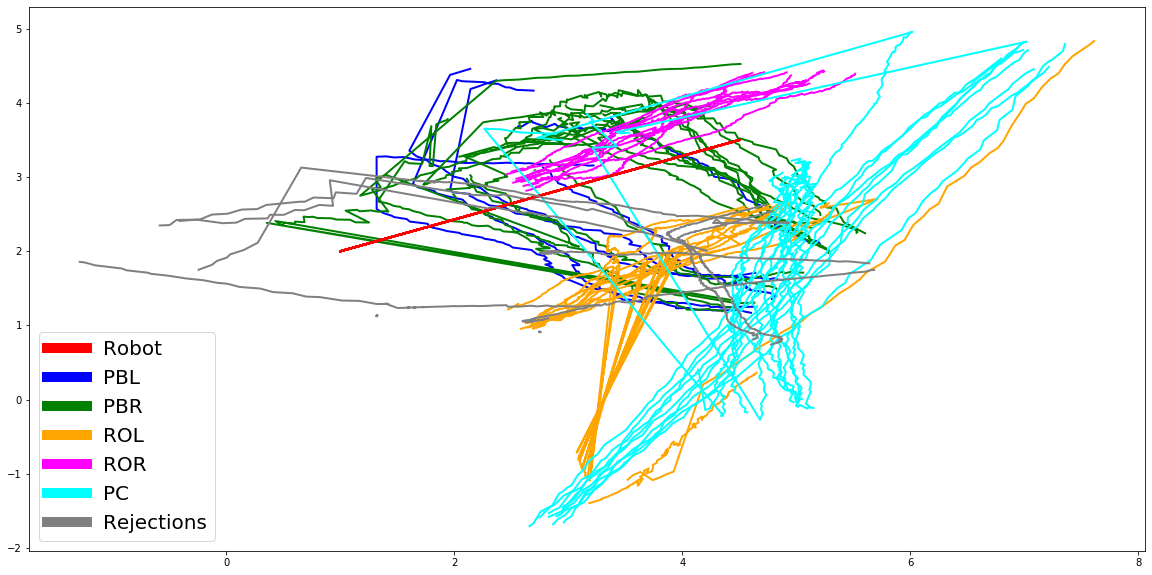

In [16]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
class_colours = ["b", "g", "orange", "magenta", "cyan", "grey"]

for class_id in range(len(label_indexed_bag_codes)):
    for bag_code in label_indexed_bag_codes[class_id]:
        bag_file_folder = "study_HRSI_rosbags/"
        bag_code_split = bag_code.split("_")
        bag_file_path = bag_file_folder + bag_code_split[0] + "/" + bag_code_split[-1] + "/pp" + bag_code_split[-1] + ".bag"
        print(bag_file_path)
        
        bag = rosbag.Bag(bag_file_path)
        
        r_xs = []
        r_ys = []

        r_state_seq = []
        for topic, msg, t in bag.read_messages(topics=['/robot5/control/odom']):
            t = t.to_sec()
            x = msg.pose.pose.position.x
            y = msg.pose.pose.position.y

            r_xs.append(x)
            r_ys.append(y)
        
        h_xs = []
        h_ys = []

        h_state_seq = []
        for topic, msg, t in bag.read_messages(topics=['/robot5/people_tracker_filtered/positions']):
            t = t.to_sec()
            try:
                x = msg.poses[0].position.x
                y = msg.poses[0].position.y

                h_xs.append(x)
                h_ys.append(y)


            except:
                pass
        bag.close()
        
        r_x_start = r_xs[0]
        r_x_end = r_xs[-1]
        r_y_start = r_ys[0]
        r_y_end = r_ys[-1]
        
        r_start_end_dist = np.sqrt(((r_x_end - r_x_start)**2) + ((r_y_end - r_y_start)**2))
        print(r_start_end_dist)

        
        if r_start_end_dist > 1:
            r_xs = np.linspace(1, 4.5, num=len(h_xs))
            r_ys = np.linspace(2, 3.5, num=len(h_ys))
        else:
            r_xs = np.linspace(1, 1, num=len(h_xs))
            r_ys = np.linspace(2, 2, num=len(h_ys))
        
        plt.plot(r_xs, r_ys, c="red", linewidth="2")
        
        h_xs = [h_xs[i] + r_xs[i] for i in range(len(h_xs))]
        h_ys = [h_ys[i] + r_ys[i] for i in range(len(h_ys))]
        
        plt.plot(h_xs, h_ys, c=class_colours[class_id], linewidth="2")
        
        
#     plt.savefig(classes[class_id]+".png")
#     plt.show()
#     input()
#     plt.close()
leg = plt.legend(np.concatenate([["Robot"], classes]), fontsize=20)
line_count = 0
for line in leg.get_lines():
    line.set_linewidth(10.0)
    if line_count == 0:
        line.set_color("r")
    else:
        line.set_color(class_colours[line_count - 1])
    
    line_count += 1


plt.show()